In [19]:
# Load required libraries for data processing, plotting, and building/evaluating the Random Forest model.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error

RANDOM_STATE = 42


In [20]:
# Load three FRED datasets and parse dates to merge and create time-based features.

caputl_path = "CAPUTLG3344S.csv"
ipg_path    = "IPG3344S.csv"
daup_path   = "DAUPSA.csv"

caputl_raw = pd.read_csv(caputl_path, parse_dates=["observation_date"])
ipg_raw    = pd.read_csv(ipg_path,    parse_dates=["observation_date"])
daup_raw   = pd.read_csv(daup_path,   parse_dates=["observation_date"])

caputl_raw.head()


,observation_date,CAPUTLG3344S
0,1972-01-01,82.6412
1,1972-02-01,80.6548
2,1972-03-01,79.9632
3,1972-04-01,80.4771
4,1972-05-01,79.9251


In [21]:

# Rename columns and merge all three datasets into single DataFrame.

caputl = caputl_raw.rename(columns={"observation_date": "DATE", "CAPUTLG3344S": "CAPUTL"})
ipg    = ipg_raw.rename(columns={"observation_date": "DATE", "IPG3344S": "IPG"})
daup   = daup_raw.rename(columns={"observation_date": "DATE", "DAUPSA": "DAUP"})

df = caputl.merge(ipg, on="DATE").merge(daup, on="DATE")

df = df.set_index("DATE").sort_index()

df.head()


,CAPUTL,IPG,DAUP
DATE,,,
1993-01-01,80.2551,0.4288,512.9
1993-02-01,80.1988,0.4334,503.8
1993-03-01,80.1333,0.4375,498.1
1993-04-01,79.6596,0.4391,510.2
1993-05-01,79.8275,0.4440,512.8


In [ ]:
# Create all engineered features: lagged values, 3-month moving averages, seasonal indicators(month/quarter), and IPG × DAUP interaction term.
# Features capture momentum, trends, seasonality, and demand–supply effects.

df["CAPUTL_lag1"] = df["CAPUTL"].shift(1)
df["CAPUTL_lag3"] = df["CAPUTL"].shift(3)

df["IPG_lag1"] = df["IPG"].shift(1)
df["IPG_lag3"] = df["IPG"].shift(3)

df["DAUP_lag3"] = df["DAUP"].shift(3)


In [23]:
df["CAPUTL_ma3"] = df["CAPUTL"].rolling(window=3).mean()
df["IPG_ma3"]    = df["IPG"].rolling(window=3).mean()


In [24]:
df["Month"]   = df.index.month
df["Quarter"] = df.index.quarter


In [25]:
df["IPG_x_DAUP"] = df["IPG"] * df["DAUP"]


In [26]:
df_full = df.dropna().copy()
df_full.head()


,CAPUTL,IPG,DAUP,CAPUTL_lag1,CAPUTL_lag3,IPG_lag1,IPG_lag3,DAUP_lag3,CAPUTL_ma3,IPG_ma3,Month,Quarter,IPG_x_DAUP
DATE,,,,,,,,,,,,,
1993-04-01,79.6596,0.4391,510.2,80.1333,80.2551,0.4375,0.4288,512.9,79.997233,0.436667,4,2,224.02882
1993-05-01,79.8275,0.4440,512.8,79.6596,80.1988,0.4391,0.4334,503.8,79.873467,0.440200,5,2,227.68320
1993-06-01,80.5937,0.4523,489.5,79.8275,80.1333,0.4440,0.4375,498.1,80.026933,0.445133,6,2,221.40085
1993-07-01,80.2468,0.4545,468.1,80.5937,79.6596,0.4523,0.4391,510.2,80.222667,0.450267,7,3,212.75145
1993-08-01,80.4144,0.4599,457.1,80.2468,79.8275,0.4545,0.4440,512.8,80.418300,0.455567,8,3,210.22029


In [27]:
# Select engineered features for modeling and define CAPUTL as the target variable.

feature_cols = [
    "CAPUTL_lag1",
    "CAPUTL_lag3",
    "IPG_lag1",
    "IPG_lag3",
    "DAUP_lag3",
    "CAPUTL_ma3",
    "IPG_ma3",
    "Month",
    "Quarter",
    "IPG_x_DAUP",
]

X = df_full[feature_cols]
y = df_full["CAPUTL"]


In [28]:
# Split the data into training (pre-2020) and testing (2020+) sets for real forecasting.

split_date = "2020-01-01"

X_train = X[X.index < split_date]
y_train = y[y.index < split_date]

X_test  = X[X.index >= split_date]
y_test  = y[y.index >= split_date]

X_train.shape, X_test.shape


((321, 10), (68, 10))

In [29]:
# Initialize Random Forest model and define the hyperparameter grid to search over using time-series cross-validation.

rf = RandomForestRegressor(
    random_state=RANDOM_STATE,
    n_jobs=-1,
)

param_grid = {
    "n_estimators": [100, 250, 500],
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
}

tscv = TimeSeriesSplit(n_splits=5)


In [30]:
# Perform GridSearchCV with time-series split to find best Random Forest hyperparameters based on MAE performance.

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=tscv,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    verbose=1,
)

grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_
best_params = grid_search.best_params_
best_cv_mae = -grid_search.best_score_

best_params, best_cv_mae


Fitting 5 folds for each of 108 candidates, totalling 540 fits


({'max_depth': 10,
  'min_samples_leaf': 4,
  'min_samples_split': 5,
  'n_estimators': 250},
 np.float64(2.182923351966444))

In [34]:
# Generate predictions on test set and compute MAE/RMSE to evaluate how tuned model generalizes to new data.
y_pred_test = best_rf.predict(X_test)

mae = mean_absolute_error(y_test, y_pred_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"Best CV MAE: {best_cv_mae:.3f}")
print(f"Test MAE:    {mae:.3f}")
print(f"Test RMSE:   {rmse:.3f}")


Best CV MAE: 2.183
Test MAE:    0.922
Test RMSE:   1.138


In [35]:
# Extract feature importance from Random Forest and display in a sorted DataFrame.
importances = best_rf.feature_importances_

feat_importance_df = (
    pd.DataFrame({"feature": feature_cols, "importance": importances})
    .sort_values("importance", ascending=False)
    .reset_index(drop=True)
)

feat_importance_df


,feature,importance
0,CAPUTL_ma3,0.665503
1,CAPUTL_lag1,0.312794
2,CAPUTL_lag3,0.008811
3,IPG_x_DAUP,0.003972
4,IPG_lag3,0.002482
5,IPG_lag1,0.002286
6,IPG_ma3,0.002074
7,DAUP_lag3,0.001042
8,Month,0.000788
9,Quarter,0.000248


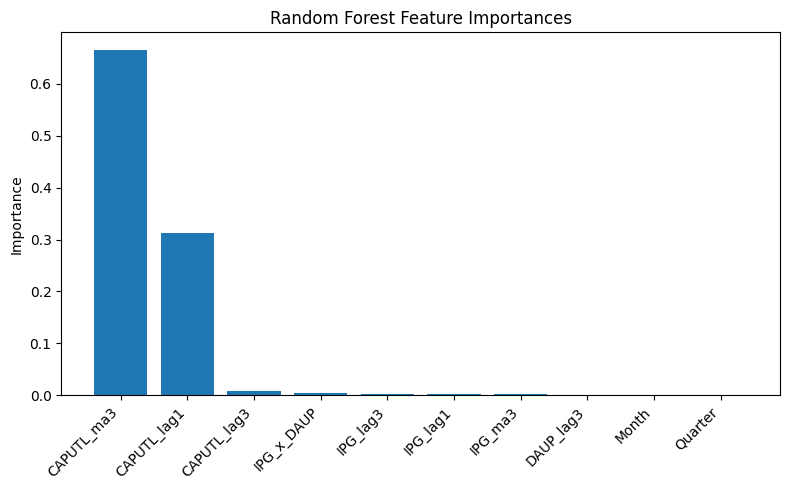

In [36]:
# Plot bar chart of feature importances to visualize most important inputs for making predictions.
plt.figure(figsize=(8, 5))
plt.bar(feat_importance_df["feature"], feat_importance_df["importance"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Importance")
plt.title("Random Forest Feature Importances")
plt.tight_layout()
plt.show()


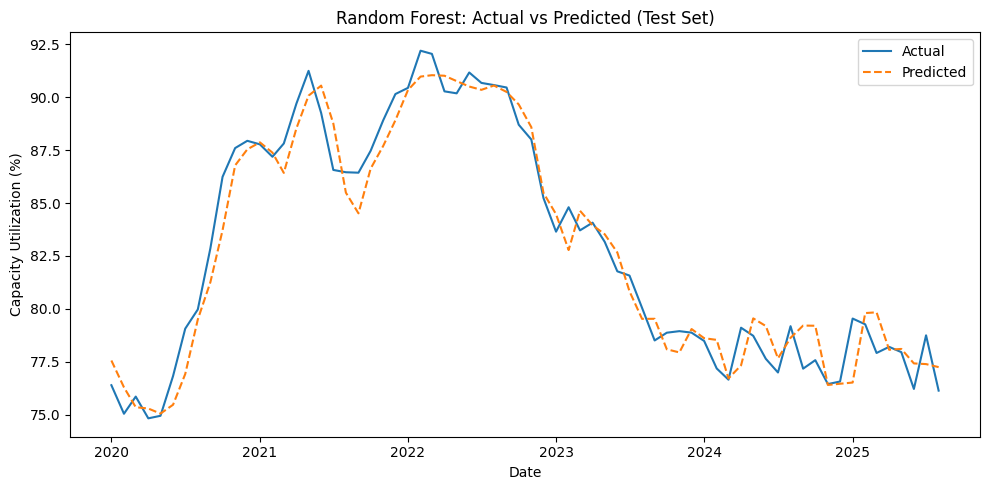

In [37]:
# Plot actual vs. predicted capacity utilization on the test set for visualization of performance.
plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test.values, label="Actual")
plt.plot(y_test.index, y_pred_test, label="Predicted", linestyle="--")
plt.xlabel("Date")
plt.ylabel("Capacity Utilization (%)")
plt.title("Random Forest: Actual vs Predicted (Test Set)")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Print summary of Random Forest model: best hyperparameters, cross-validated training error, test performance metrics, and top feature importances.

print("Random Forest Model Summary")
print("Best hyperparameters:")
for k, v in best_params.items():
    print(f"  {k}: {v}")

print(f"\nBest CV MAE: {best_cv_mae:.3f}")
print(f"Test MAE:    {mae:.3f}")
print(f"Test RMSE:   {rmse:.3f}")

print("\nFeature Importances (top 5):")
print(feat_importance_df.head())


Random Forest Model Summary
Best hyperparameters:
  max_depth: 10
  min_samples_leaf: 4
  min_samples_split: 5
  n_estimators: 250

Best CV MAE: 2.183
Test MAE:    0.922
Test RMSE:   1.138

Feature Importances (top 5):
       feature  importance
0   CAPUTL_ma3    0.665503
1  CAPUTL_lag1    0.312794
2  CAPUTL_lag3    0.008811
3   IPG_x_DAUP    0.003972
4     IPG_lag3    0.002482
